# Replicating the Police Diversion Analysis

This document provides a breakdown and replication of the methodology used in the 2021 review of the Cahoots organization done by the EPD Crime Analysis unit. Below are the formulas used in the calculation of the diversion rates mentioned in the paper. (Formulations Have not yet been updated to reflect code changes)

### Gross Diversion Rates

| Rate | Formula | Description |
|---|---|---|
| **Diversion Rate 1** |  $\frac{\text{CAHOOTS Associations}}{\text{Total Calls}}$  | This rate represents all instances where CAHOOTS was associated with a call, regardless of dispatch or arrival status. |
| **Diversion Rate 2** | $\frac{\text{CAHOOTS Dispatched}}{\text{Total Calls}}$ | This rate considers calls where CAHOOTS was dispatched. |
| **Diversion Rate 3** | $\frac{\text{CAHOOTS Only Arrived}}{\text{Total Calls}}$  | This rate considers all calls where CAHOOTS alone arrived at the scene. |

### Adjusted Diversion Rates

| Rate | Formula | Description |
|---|---|---|
| **Diversion Rate 4** | $\frac{\text{CAHOOTS Only Arrived} - (\text{Count of top 3 Cahoots incidents (dataset 5)})}{\text{Total Calls}}$  | Removes the total count of the 3 most common call types handled by Cahoots from the numerator. |
| **Diversion Rate 5** | $\frac{\text{CAHOOTS Only Arrived} - (\text{Count of top 3 Cahoots incidents (dataset 5)})}{\text{(Arrived only calls) - (Count of top 3 Cahoots incidents (dataset 5))}}$  | Similar to Diversion Rate 4, but only considers calls that arrived on scene. |
| **Diversion Rate 6 (Low)** | $\frac{\text{(Count of Dispatched Cahoots Welfare Calls) * 0.74}}{\text{Total Calls}}$ | Assumes that Welfare check is the only diverted call type and that 0.74 are diversions. |
| **Diversion Rate 6 (High)** | $\frac{\text{(Count of Dispatched Cahoots Welfare Calls) * 0.74}}{\text{(Dispatched only calls) - (Arrival count of Cahoots incidents - wellfare count)}}$  | Similar to Diversion Rate 6 (Low), but calculated using the adjusted total for dispatched calls (arrived only). |


# Police Diverson Criteria

* Call is recieved by the call center
* Police are normally dispatched to call type
* The call is dispatched to and arrived at by Cahoots
* No EPD Resources are dispatched to the call

# Exact Replication of the numbers

The exact calculations are not provided in the study so I extracted the relevant counts from the available figures, and just used the stated number when raw totals were not visable. The fact that many exact calculations are not shown means that some re-engineering was involved in deriving these formulas. 

In [1]:
# --- CAHOOTS Data ---
cahoots_total_assoc = 22055 

# dispatch
cahoots_dispatches = 18106
cahoots_dispatches_check_welfare = 5546 # 6003
cahoots_dispatches_transport = 1803 
cahoots_dispatches_assist = 5788

# arrival
cahoots_arrivals_solo = 14212
cahoots_arrivals_assist_public = 5058
cahoots_arrivals_check_welfare = 5022
cahoots_arrivals_transport = 1587

# --- EPD Data ---
epd_total_calls = 109854 
epd_dispatches_and_cahoots = 68427

# Calculated EPD dispatch count (excluding cases with CAHOOTS)
epd_dispatches_solo = epd_dispatches_and_cahoots - cahoots_dispatches  


# 1. Gross Divert Rates 
diversion_rate_associations = (cahoots_total_assoc / epd_total_calls) * 100
diversion_rate_dispatches = (cahoots_dispatches / epd_total_calls) * 100
diversion_rate_cahoots_only_arrivals = (cahoots_arrivals_solo / epd_total_calls) * 100

# 2. Diversion Rate (Removing Top 3 Cahoots Calls)
# Methodology error: Calls are not removed from the denom which makes the number artificially lower, it would be closer to 3% otherwise
diversion_rate_removing_centric_calls =  ((cahoots_arrivals_solo - cahoots_arrivals_assist_public - cahoots_arrivals_check_welfare - cahoots_arrivals_transport) / epd_total_calls) * 100

# The paper incorrectly presents this number as dealing with dispatches without the top 3 incident types. To replicate the exact numbers, we must use the arrival only cahoots counts in the numerator,
# but use the total dispactched count in the denominator (while only subtracting the arrival counts from the denominator) . 
diversion_rate_removing_centric_calls_dispatch =  ((cahoots_arrivals_solo - cahoots_arrivals_assist_public - cahoots_arrivals_check_welfare - cahoots_arrivals_transport) / 
                                                   (epd_dispatches_and_cahoots - cahoots_arrivals_transport - cahoots_arrivals_check_welfare - cahoots_arrivals_assist_public)) * 100


# 3. Diversion Rate welfare check adjusted 

# The weirdness continues. The paper claims we are now examining the dispatched cahoots check welfare calls in 2021, citing 5546 as the total number of calls in this category. 
# The problem? Fig. 2 in the paper shows the counts of each dispatched cahoots call type and the true number is 6003. I thought that this might be similar to the calculations above, 
# where arrivals were incorrectly called dispatches. However, for arrivals the number is 5425(Fig. 3) and for strict cahoots arrivals, the number is 5002 (Fig. 5).
# It is possible that this is a result of the figures being generated after more data came in but this should be clarified. 

# Diversion Rate welfare check adjusted (Low)
CHECK_WELFARE_EPD_PROBABILITY = 0.74 
estimated_epd_check_welfare = CHECK_WELFARE_EPD_PROBABILITY * cahoots_dispatches_check_welfare

diversion_rate_adjusted_all_calls = (estimated_epd_check_welfare / epd_total_calls) * 100

# Diversion Rate welfare check adjusted (High)
diversion_rate_adjusted_dispatched_calls_high = (estimated_epd_check_welfare / (epd_dispatches_and_cahoots - (cahoots_dispatches - estimated_epd_check_welfare))* 100 )

# --- Output ---
print(f"1a. Diversion Rate (Associations): {diversion_rate_associations:.1f}%")
print(f"1b. Diversion Rate (Dispatches): {diversion_rate_dispatches:.1f}%")
print(f"1c. Diversion Rate (CAHOOTS Only Arrivals): {diversion_rate_cahoots_only_arrivals:.1f}%")
print(f"2a. Diversion Rate (Removing CAHOOTS-Centric Calls): {diversion_rate_removing_centric_calls:.1f}%")
print(f"2b. Diversion Rate (Removing CAHOOTS-Centric Calls, Dispatch only): {diversion_rate_removing_centric_calls_dispatch:.1f}%")
print(f"3a. Diversion Rate (Adjusted for Check Welfare - All Calls): {diversion_rate_adjusted_all_calls:.1f}%")
print(f"3b. Diversion Rate (Adjusted for Check Welfare - Dispatched Calls): {diversion_rate_adjusted_dispatched_calls_high:.1f}%")

1a. Diversion Rate (Associations): 20.1%
1b. Diversion Rate (Dispatches): 16.5%
1c. Diversion Rate (CAHOOTS Only Arrivals): 12.9%
2a. Diversion Rate (Removing CAHOOTS-Centric Calls): 2.3%
2b. Diversion Rate (Removing CAHOOTS-Centric Calls, Dispatch only): 4.5%
3a. Diversion Rate (Adjusted for Check Welfare - All Calls): 3.7%
3b. Diversion Rate (Adjusted for Check Welfare - Dispatched Calls): 7.5%


### To get the final range you have to assume that the only type of call that cahoots can divert is a wellfare check. 

In [2]:
import pandas as pd

file_path = 'Data/cleaned_data/cleaned_CAD_data_2021.csv'
cleaned_data = pd.read_csv(file_path)

datetime_columns = ['Call_Created_Time', 'Call_First_Dispatched_Time', 'Call_First_On_Scene', 'Call_Cleared']
for col in datetime_columns:
    cleaned_data[col] = pd.to_datetime(cleaned_data[col], errors='coerce')
    
cleaned_data = cleaned_data.dropna(subset=['Call_Created_Time', 'Call_Source', 'InitialIncidentTypeDescription'])
cleaned_data

,IncidentNumber,Call_Created_Time,Call_First_Dispatched_Time,Call_First_On_Scene,Call_Cleared,Call_Zipcode,Beat,Call_Source,Call_Priority,InitialIncidentTypeDescription,IsPrimary,PrimaryUnitCallSign,RespondingUnitCallSign,Unit_Dispatched_Time,Unit_OnScene_Time,Unit_Cleared_Time,Disposition,year,Cahoots_related
0,OR-2021-01-01-21000001,2021-01-01 00:00:58,2021-01-01 00:22:41,NaT,2021-01-01 00:22:47,97403.0,EP03,PHONE,5,BEAT INFORMATION,1,6E31,6E31,01/01/2021 00:22:41,NaN,01/01/2021 00:22:47,INFORMATION ONLY,2021,0
1,OR-2021-01-01-21000002,2021-01-01 00:01:03,NaT,NaT,NaT,97404.0,LS13,E911,5,ILLEGAL FIREWORKS,0,NaN,NaN,NaN,NaN,NaN,RELAYED TO LANE COUNTY SHERIFFS OFFICE,2021,0
2,OR-2021-01-01-21000004,2021-01-01 00:01:48,2021-01-01 00:02:53,2021-01-01 00:06:38,2021-01-01 00:23:46,97402.0,EP05,W911,3,TRAFFIC HAZARD,1,4E53,4E53,01/01/2021 00:18:25,01/01/2021 00:18:25,01/01/2021 00:23:46,PATROL CHECK,2021,0
3,OR-2021-01-01-21000004,2021-01-01 00:01:48,2021-01-01 00:02:53,2021-01-01 00:06:38,2021-01-01 00:23:46,97402.0,EP05,W911,3,TRAFFIC HAZARD,0,4E53,5E47,01/01/2021 00:02:53,01/01/2021 00:06:38,01/01/2021 00:23:33,PATROL CHECK,2021,0
4,OR-2021-01-01-21000004,2021-01-01 00:01:48,2021-01-01 00:02:53,2021-01-01 00:06:38,2021-01-01 00:23:46,97402.0,EP05,W911,3,TRAFFIC HAZARD,0,4E53,CMD16,01/01/2021 00:07:49,01/01/2021 00:07:49,01/01/2021 00:14:38,PATROL CHECK,2021,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217278,OR-2021-12-31-21336952,2021-12-31 23:51:41,2021-12-31 23:51:41,2021-12-31 23:51:41,2022-01-01 00:18:31,97401.0,EP02,SELF,P,FIGHT,0,4F64,4E23,01/01/2022 00:02:03,01/01/2022 00:03:28,01/01/2022 00:18:31,CITED IN LIEU OF CUSTODY,2021,0
217279,OR-2021-12-31-21336952,2021-12-31 23:51:41,2021-12-31 23:51:41,2021-12-31 23:51:41,2022-01-01 00:18:31,97401.0,EP02,SELF,P,FIGHT,1,4F64,4F64,12/31/2021 23:51:41,12/31/2021 23:51:41,01/01/2022 00:18:10,CITED IN LIEU OF CUSTODY,2021,0
217280,OR-2021-12-31-21336952,2021-12-31 23:51:41,2021-12-31 23:51:41,2021-12-31 23:51:41,2022-01-01 00:18:31,97401.0,EP02,SELF,P,FIGHT,0,4F64,4F65,12/31/2021 23:51:41,12/31/2021 23:51:41,01/01/2022 00:18:10,CITED IN LIEU OF CUSTODY,2021,0
217281,OR-2021-12-31-21336961,2021-12-31 23:59:50,NaT,NaT,NaT,97402.0,EP05,E911,1,POISONING,0,NaN,NaN,NaN,NaN,NaN,DISREGARD,2021,0


In [3]:
import pandas as pd

def run_police_diversions(cleaned_data, welfare_prop, transport_prop=0, assist_prop=0, suicide_prop=0):
    # Filtering out the 'SELF' entries from the dataset
    data_filtered = cleaned_data[cleaned_data['Call_Source'] != 'SELF']

    # Dataset 1: ALL CAHOOTS ASSOCIATIONS
    cahoots_associations = data_filtered[data_filtered['Cahoots_related'] == 1]

    # Dataset 2: ALL CAHOOTS DISPATCHED CFS
    cahoots_dispatched = cahoots_associations.dropna(subset=['Call_First_Dispatched_Time'])
    cahoots_dispatched = cahoots_dispatched.drop_duplicates(subset='IncidentNumber', keep='first')
    
    # Dataset 4: ALL CAHOOTS ONLY ASSOCIATIONS
    cahoots_only_associations = cahoots_associations[(cahoots_associations['PrimaryUnitCallSign'] == "CAHOOT") & (cahoots_associations['IsPrimary'] == 1)]
    
    # Dataset 5: CAHOOTS ONLY ARRIVED CFS
    cahoots_only_arrived = cahoots_only_associations.dropna(subset=['Call_First_On_Scene'])
    cahoots_only_arrived = cahoots_only_arrived.drop_duplicates(subset='IncidentNumber', keep='first')
    
    # Dataset 6: Total CAHOOTS / EPD responses
    data_unique_incidents = data_filtered.drop_duplicates(subset='IncidentNumber', keep='first')
    combined_cahoots_epd_responses = data_unique_incidents[~(data_unique_incidents["Call_First_Dispatched_Time"].isna())] # Switch between dispatch and arrival
    
    # Calculate total calls
    total_calls = data_unique_incidents.shape[0]

    # Filter top 3 CAHOOTS CFS natures arrive
    top_3_natures = ['ASSIST PUBLIC- POLICE', 'CHECK WELFARE', 'TRANSPORT']
    top_3_cahoots_natures = cahoots_only_arrived[cahoots_only_arrived['InitialIncidentTypeDescription'].isin(top_3_natures)]
    top_3_cahoots_natures_count = top_3_cahoots_natures.shape[0]
    
    # Gross Divert Rates
    gross_divert_rate_1 = (cahoots_associations.shape[0] / total_calls) * 100
    gross_divert_rate_2 = (cahoots_dispatched.shape[0] / total_calls) * 100
    gross_divert_rate_3 = (cahoots_only_arrived.shape[0] / total_calls) * 100

    # Divert Rate without top 3 incident types 
    adjusted_cahoots_only_arrived = cahoots_only_arrived.shape[0] - top_3_cahoots_natures_count
    adjusted_divert_rate = (adjusted_cahoots_only_arrived / total_calls) * 100
    
    # Divert Rate without top 3 incident types Arrived only 
    adjusted_cahoots_police_arrived = ((cahoots_only_arrived.shape[0] - top_3_cahoots_natures_count) / 
                                          (combined_cahoots_epd_responses.shape[0] - top_3_cahoots_natures_count)) * 100

    # Applying 0.74 adjustment to Check Welfare calls
    likely_check_welfare_diverts_dispatch = (cahoots_dispatched[cahoots_dispatched["InitialIncidentTypeDescription"] == 'CHECK WELFARE'].shape[0]) * welfare_prop
    likely_transport_diverts_dispatch = (cahoots_dispatched[cahoots_dispatched["InitialIncidentTypeDescription"] == 'TRANSPORT'].shape[0]) * transport_prop
    likely_assist_diverts_dispatch = (cahoots_dispatched[cahoots_dispatched["InitialIncidentTypeDescription"] == 'ASSIST PUBLIC- POLICE'].shape[0]) * assist_prop
    likely_suicide_diverts = (cahoots_dispatched[cahoots_dispatched["InitialIncidentTypeDescription"] == 'SUICIDAL SUBJECT'].shape[0]) * suicide_prop
    
    
    likely_divert_sum = likely_check_welfare_diverts_dispatch + likely_transport_diverts_dispatch + likely_assist_diverts_dispatch + likely_suicide_diverts
    
    # low estimate
    adjusted_divert_rate_with_welfare = ((likely_divert_sum) / total_calls) * 100
    
    # High estimate
    adjusted_divert_rate_with_welfare_high = (likely_divert_sum / ((combined_cahoots_epd_responses.shape[0]) - (cahoots_dispatched.shape[0] - likely_divert_sum))) * 100
    
    # Final Results
    results = {
        "Gross Divert Rate 1 (All Cahoots Associations)": gross_divert_rate_1,
        "Gross Divert Rate 2 (All Cahoots Dispatched CFS)": gross_divert_rate_2,
        "Gross Divert Rate 3 (All Cahoots Arrived CFS)": gross_divert_rate_3,
        "Adjusted Divert Rate (Excluding Top 3 Natures)": adjusted_divert_rate,
        "Adjusted Divert Rate (Excluding Top 3 Natures Arrived only)": adjusted_cahoots_police_arrived,
        "Adjusted Divert Rate with Check Welfare Adjustment (low)": adjusted_divert_rate_with_welfare,
        "Adjusted Divert Rate with Check Welfare Adjustment (high)": adjusted_divert_rate_with_welfare_high
    }

    return {
        'cahoots_associations': cahoots_associations,
        'cahoots_dispatched': cahoots_dispatched,
        'cahoots_only_associations': cahoots_only_associations,
        'cahoots_only_arrived': cahoots_only_arrived,
        'total_cahoots_epd_responses': combined_cahoots_epd_responses,
        'results': results
    }

# Example usage:
datasets_and_results = run_police_diversions(cleaned_data, 0.74)
datasets_and_results['results']


{'Gross Divert Rate 1 (All Cahoots Associations)': 20.755246527966392,
 'Gross Divert Rate 2 (All Cahoots Dispatched CFS)': 16.41045140963659,
 'Gross Divert Rate 3 (All Cahoots Arrived CFS)': 13.431835877378816,
 'Adjusted Divert Rate (Excluding Top 3 Natures)': 2.580259655603238,
 'Adjusted Divert Rate (Excluding Top 3 Natures Arrived only)': 5.02929342838992,
 'Adjusted Divert Rate with Check Welfare Adjustment (low)': 4.024462672243649,
 'Adjusted Divert Rate with Check Welfare Adjustment (high)': 8.086088525349998}

In [4]:
fig = 0
for i in list(datasets_and_results.keys())[:-1]:
    fig += 1
    # Create a DataFrame from the value counts
    count_series = datasets_and_results[i]['InitialIncidentTypeDescription'].value_counts()
    top_10 = count_series.head(10)
    other_count = count_series[10:].sum()
    
    # Create DataFrame for top 10
    df = pd.DataFrame(top_10).reset_index()
    df.columns = ['Incident Type', 'Count']
    
    # Create 'Other' row
    other_row = pd.DataFrame([{'Incident Type': 'Other', 'Count': other_count}])
    
    # Concatenate the top 10 DataFrame with the 'Other' row
    df = pd.concat([df, other_row], ignore_index=True)
    
    # Calculate the percentage of total calls
    total_calls = count_series.sum()
    df['Percentage of Total Calls'] = ((df['Count'] / total_calls) * 100).round(2).astype(str) + '%'
    
    # Display the DataFrame
    print(f"Figure {fig}: {i}")
    display(df)

Figure 1: cahoots_associations


,Incident Type,Count,Percentage of Total Calls
0,CHECK WELFARE,7615,33.22%
1,ASSIST PUBLIC- POLICE,7330,31.97%
2,TRANSPORT,2352,10.26%
3,SUICIDAL SUBJECT,1935,8.44%
4,DISORDERLY SUBJECT,543,2.37%
5,TRAFFIC HAZARD,444,1.94%
6,DISPUTE,328,1.43%
7,INTOXICATED SUBJECT,284,1.24%
8,CRIMINAL TRESPASS,278,1.21%
9,ASSIST FIRE DEPARTMENT,240,1.05%


Figure 2: cahoots_dispatched


,Incident Type,Count,Percentage of Total Calls
0,CHECK WELFARE,6007,33.14%
1,ASSIST PUBLIC- POLICE,5792,31.95%
2,TRANSPORT,1808,9.97%
3,SUICIDAL SUBJECT,1571,8.67%
4,DISORDERLY SUBJECT,457,2.52%
5,TRAFFIC HAZARD,372,2.05%
6,DISPUTE,256,1.41%
7,CRIMINAL TRESPASS,231,1.27%
8,INTOXICATED SUBJECT,219,1.21%
9,FOUND SYRINGE,192,1.06%


Figure 3: cahoots_only_associations


,Incident Type,Count,Percentage of Total Calls
0,ASSIST PUBLIC- POLICE,5715,35.02%
1,CHECK WELFARE,5708,34.98%
2,TRANSPORT,1788,10.96%
3,SUICIDAL SUBJECT,1301,7.97%
4,TRAFFIC HAZARD,329,2.02%
5,DISORDERLY SUBJECT,240,1.47%
6,INTOXICATED SUBJECT,206,1.26%
7,FOUND SYRINGE,191,1.17%
8,ASSIST FIRE DEPARTMENT,178,1.09%
9,DISORIENTED SUBJECT,132,0.81%


Figure 4: cahoots_only_arrived


,Incident Type,Count,Percentage of Total Calls
0,CHECK WELFARE,5222,35.2%
1,ASSIST PUBLIC- POLICE,5158,34.77%
2,TRANSPORT,1606,10.83%
3,SUICIDAL SUBJECT,1210,8.16%
4,TRAFFIC HAZARD,307,2.07%
5,DISORDERLY SUBJECT,218,1.47%
6,INTOXICATED SUBJECT,187,1.26%
7,ASSIST FIRE DEPARTMENT,163,1.1%
8,FOUND SYRINGE,160,1.08%
9,DISORIENTED SUBJECT,124,0.84%


Figure 5: total_cahoots_epd_responses


,Incident Type,Count,Percentage of Total Calls
0,CHECK WELFARE,8666,12.62%
1,DISPUTE,6447,9.39%
2,ASSIST PUBLIC- POLICE,6086,8.86%
3,CRIMINAL TRESPASS,4975,7.25%
4,BEAT INFORMATION,4851,7.07%
5,DISORDERLY SUBJECT,3597,5.24%
6,SUICIDAL SUBJECT,1973,2.87%
7,TRANSPORT,1866,2.72%
8,SUSPICIOUS CONDITIONS,1779,2.59%
9,TRAFFIC HAZARD,1745,2.54%


### We now have a small over estimation but this overestimation is consistent across datasets so it can be corrected for 

# Problems
- Assumption of Uniform Impact: The analysis assumes that the impact of Cahoots on diversion rates is uniform across all incident types. This does not factor in which CAD call types are appropriate for Cahoots.

- The approach of simply excluding the top three Cahoots-centric incident types assumes that these calls would never require police intervention. However, police still Respond to quite a few of these call types.

- Trying to measure what call volume would be if Cahoots did not exist does not make sense since Cahoots provides other preventative community services that could reduce call volume. 

- The methodology for the 74% figure is vauge and somewhat subjective (Based on Dispatchers opinion)




# Natural Experiment

The Eugene Police Department (EPD) claims that 74% of "Check Welfare" calls are eligible for diversion by CAHOOTS. This figure, derived from a 2019 analysis of 200 calls, lacks transparency in its methodology and relies solely on the opinions of an unspecified number of dispatchers, raising concerns about its reliability.

While it's impossible to definitively determine the impact of CAHOOTS' absence, we can analyze the program's expansion in 2017. Before then, calls received between the hours 5am-10am fell under the EPD's jurisdiction and, theoretically, were eligible for diversion. If the 74% figure holds true, we should see a significant increase in dispatched calls for non-divertible incident types between 2016 and 2017, after CAHOOTS expanded its service hours. 

Indeed, comparing the ratio of calls between 2016 and 2017 for each incident type can provide a more objective basis for adjusting the estimated proportion of calls eligible for diversion. This approach minimizes reliance on subjective assessments and offers a more data-driven perspective on the true proportion of divertable calls. Future research could establish a more robust baseline with access to data going back farther than 2016. 

### Standard data cleaning 

In [5]:
CAD_data = pd.read_csv("data/call_data_from_CAD.csv")

CAD_data["Call_Created_Time"] = pd.to_datetime(CAD_data['Call_Created_Time'], errors='coerce')
CAD_data["year"] = CAD_data["Call_Created_Time"].dt.year
CAD_data["Call_First_Dispatched_Time"] = pd.to_datetime(CAD_data['Call_First_Dispatched_Time'], errors='coerce')

# Standardize Cahoots identifiers 
cahoots_identifiers = r"1J77\s*|3J79\s*|3J78\s*|3J77\s*|4J79\s*|3J81\s*|3J76\s*|2J28\s*|2J29\s*|CAHOOT\s*|CAHOT\s*|CAHO\s*"

CAD_data["PrimaryUnitCallSign"] = CAD_data["PrimaryUnitCallSign"].replace(cahoots_identifiers, 'CAHOOT', regex=True)
CAD_data["RespondingUnitCallSign"] = CAD_data["RespondingUnitCallSign"].replace(cahoots_identifiers, 'CAHOOT', regex=True)
# Standardize Cahoots identifiers 
cahoots_identifiers = r"1J77\s*|3J79\s*|3J78\s*|3J77\s*|4J79\s*|3J81\s*|3J76\s*|2J28\s*|2J29\s*|CAHOOT\s*|CAHOT\s*|CAHO\s*"

CAD_data["PrimaryUnitCallSign"] = CAD_data["PrimaryUnitCallSign"].replace(cahoots_identifiers, 'CAHOOT', regex=True)
CAD_data["RespondingUnitCallSign"] = CAD_data["RespondingUnitCallSign"].replace(cahoots_identifiers, 'CAHOOT', regex=True)

# Create an identifier for Cahoots involvement 
CAD_data['Cahoots_related'] = ((CAD_data['PrimaryUnitCallSign'] == 'CAHOOT') | (CAD_data['RespondingUnitCallSign'] == 'CAHOOT')).astype(int)

In [6]:
CAD_data = CAD_data[CAD_data['Call_Source'] != 'SELF'].copy()
CAD_data.drop(columns=["Unnamed: 0"], inplace=True)

In [7]:
data_2016 = CAD_data[(CAD_data["Call_First_Dispatched_Time"].dt.year == 2016) & 
                         (CAD_data["Call_First_Dispatched_Time"].dt.hour >= 5) & 
                         (CAD_data["Call_First_Dispatched_Time"].dt.hour < 10)].copy()

data_2017 = CAD_data[(CAD_data["Call_First_Dispatched_Time"].dt.year == 2017) & 
                         (CAD_data["Call_First_Dispatched_Time"].dt.hour >= 5) & 
                         (CAD_data["Call_First_Dispatched_Time"].dt.hour < 10)].copy()

data_2016.dropna(subset=['Call_First_Dispatched_Time'], inplace=True)
data_2017.dropna(subset=['Call_First_Dispatched_Time'], inplace=True)

## Running the Experiment

In [8]:
def calculate_prop(data_2016, data_2017, types):
    dict_2016 = data_2016[data_2016["InitialIncidentTypeDescription"].isin(types)]["InitialIncidentTypeDescription"].value_counts().to_dict()
    dict_2017 = data_2017[data_2017["InitialIncidentTypeDescription"].isin(types)]["InitialIncidentTypeDescription"].value_counts().to_dict()
    
    final_dict = {}
    for incident in dict_2016:
        final_dict[incident] = dict_2016[incident] / dict_2017[incident]
    return final_dict
        
        
calculate_prop(data_2016, data_2017, ["CHECK WELFARE"])

{'CHECK WELFARE': 0.9625275532696547}

For the Check welfare category, we find very little change in call volume from 2016 to 2017 during the hours of 5am - 10am. This indicates that the vast majority of Check Welfare calls are eligible for diversion, and that the 0.74 figure is likely an significant undercount. Keeping all else equal, let's rerun the diversion rates:

In [9]:
welfare_prop = calculate_prop(data_2016, data_2017, ["CHECK WELFARE"])["CHECK WELFARE"]
wellfare_corrected_results = run_police_diversions(cleaned_data, welfare_prop, 0, 0)
wellfare_corrected_results['results']

{'Gross Divert Rate 1 (All Cahoots Associations)': 20.755246527966392,
 'Gross Divert Rate 2 (All Cahoots Dispatched CFS)': 16.41045140963659,
 'Gross Divert Rate 3 (All Cahoots Arrived CFS)': 13.431835877378816,
 'Adjusted Divert Rate (Excluding Top 3 Natures)': 2.580259655603238,
 'Adjusted Divert Rate (Excluding Top 3 Natures Arrived only)': 5.02929342838992,
 'Adjusted Divert Rate with Check Welfare Adjustment (low)': 5.234670552891535,
 'Adjusted Divert Rate with Check Welfare Adjustment (high)': 10.268003855748532}

With no other adjustments, our diversion rate is now somewhere between 5% - 10%. However, in reality, check welfare is far from the only divertable call type. Let's now examine the proportions of the top 4 cahoots incident types and consider them in our calculations.

In [10]:
incidents = ["CHECK WELFARE", "TRANSPORT", "ASSIST PUBLIC- POLICE", "SUICIDAL SUBJECT"]
correct_props = calculate_prop(data_2016, data_2017, incidents)
correct_props

{'CHECK WELFARE': 0.9625275532696547,
 'SUICIDAL SUBJECT': 0.7832817337461301,
 'ASSIST PUBLIC- POLICE': 0.22984562607204118,
 'TRANSPORT': 0.14871794871794872}

In [11]:
welfare_prop = correct_props["CHECK WELFARE"]
transport_prop = correct_props["TRANSPORT"]
assist_prop = correct_props["ASSIST PUBLIC- POLICE"]
suicide_prop = correct_props["SUICIDAL SUBJECT"]

top_3_corrected_results = run_police_diversions(cleaned_data, welfare_prop, transport_prop, assist_prop, suicide_prop)
top_3_corrected_results['results']

{'Gross Divert Rate 1 (All Cahoots Associations)': 20.755246527966392,
 'Gross Divert Rate 2 (All Cahoots Dispatched CFS)': 16.41045140963659,
 'Gross Divert Rate 3 (All Cahoots Arrived CFS)': 13.431835877378816,
 'Adjusted Divert Rate (Excluding Top 3 Natures)': 2.580259655603238,
 'Adjusted Divert Rate (Excluding Top 3 Natures Arrived only)': 5.02929342838992,
 'Adjusted Divert Rate with Check Welfare Adjustment (low)': 7.797441952031886,
 'Adjusted Divert Rate with Check Welfare Adjustment (high)': 14.562903478797923}

With these adjustments our range is now 8% - 15%. Our low end estimation has now caught up with the EPD's max estimate suggesting that the proportion of divertable call types is much higher than originally claimed. This number is still a low ball estimate in many respects but this serves as a useful baseline diversion rate. 

In [12]:
CAD_data_diversions = pd.read_csv("data/cleaned_data/cleaned_CAD_data_diversions.csv")

In [13]:
datetime_columns = ['Call_Created_Time', 'Call_First_Dispatched_Time', 'Call_First_On_Scene', 'Call_Cleared']
for col in datetime_columns:
    CAD_data_diversions[col] = pd.to_datetime(CAD_data_diversions[col], errors='coerce')
    
CAD_data_cleaned = CAD_data_diversions.dropna(subset=['Call_Created_Time', 'Call_Source', 'InitialIncidentTypeDescription'])

In [14]:
test = run_police_diversions(CAD_data_cleaned[CAD_data_cleaned["Call_Created_Time"].dt.year == 2017], welfare_prop)
test['results']

{'Gross Divert Rate 1 (All Cahoots Associations)': 20.1387881926463,
 'Gross Divert Rate 2 (All Cahoots Dispatched CFS)': 16.16882444329363,
 'Gross Divert Rate 3 (All Cahoots Arrived CFS)': 12.827550491973073,
 'Adjusted Divert Rate (Excluding Top 3 Natures)': 2.310719834282755,
 'Adjusted Divert Rate (Excluding Top 3 Natures Arrived only)': 4.4692401690739,
 'Adjusted Divert Rate with Check Welfare Adjustment (low)': 4.39542618577515,
 'Adjusted Divert Rate with Check Welfare Adjustment (high)': 8.71310065330718}

In [15]:
CAD_data_cleaned_filter = CAD_data_cleaned[(CAD_data_cleaned["Call_Created_Time"].dt.year >= 2017) & (CAD_data_cleaned["Call_Created_Time"].dt.year <= 2021)]

In [16]:
test = run_police_diversions(CAD_data_cleaned_filter[CAD_data_cleaned_filter["Call_Created_Time"].dt.year >= 2017], welfare_prop, transport_prop, assist_prop, suicide_prop)
test['results']

{'Gross Divert Rate 1 (All Cahoots Associations)': 20.676778100114873,
 'Gross Divert Rate 2 (All Cahoots Dispatched CFS)': 16.730593251689026,
 'Gross Divert Rate 3 (All Cahoots Arrived CFS)': 13.472479118397226,
 'Adjusted Divert Rate (Excluding Top 3 Natures)': 2.475613792566344,
 'Adjusted Divert Rate (Excluding Top 3 Natures Arrived only)': 4.859972403459888,
 'Adjusted Divert Rate with Check Welfare Adjustment (low)': 7.3368560813049895,
 'Adjusted Divert Rate with Check Welfare Adjustment (high)': 13.963800157749395}

In [17]:
diversion_rates_by_year = {}
for year in range(2017, 2022):  # Loop through years 2017 to 2021
    # Filter data for the current year
    yearly_data = CAD_data_cleaned[CAD_data_cleaned["Call_Created_Time"].dt.year == year]
    
    # Calculate diversion rates for the filtered yearly data
    yearly_rates = run_police_diversions(yearly_data, welfare_prop, transport_prop, assist_prop, suicide_prop)
    
    # Store the results in the dictionary
    diversion_rates_by_year[year] = yearly_rates['results']

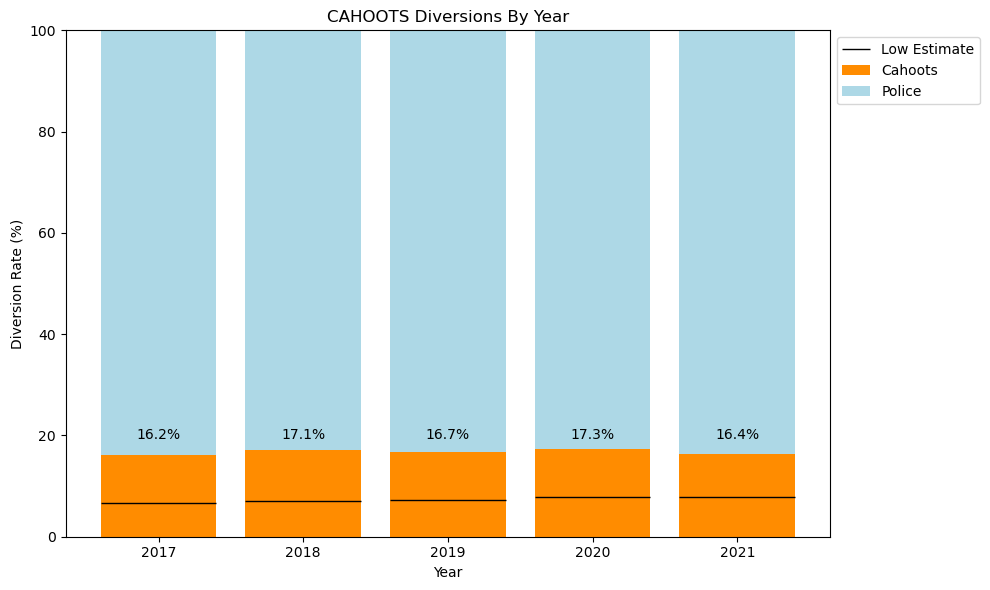

In [18]:
import matplotlib.pyplot as plt

def create_diversion_rate_chart(data, rate_key, low_estimate_key=None, 
                                 title=None, rate_label=None, low_estimate_label='Low Estimate'):
    """
    Creates a stacked bar chart showing diversion rates by year.

    Args:
        data (dict): A dictionary where keys are years and values are
                     dictionaries containing diversion rate information.
        rate_key (str): The key for the diversion rate to plot.
        low_estimate_key (str, optional): The key for the low-end estimate 
                                           to add as a line. If None, no line 
                                           is added. Defaults to None.
        title (str, optional): Title for the plot. If None, a default title is used.
        rate_label (str, optional): Label for the main rate in the legend. 
                                    If None, the `rate_key` is used as the label.
        low_estimate_label (str, optional): Label for the low estimate line 
                                            in the legend. Defaults to 'Low Estimate'.
    """

    years = list(data.keys())
    rates = list(data.values())

    selected_rates = [rate[rate_key] for rate in rates]

    plt.figure(figsize=(10, 6))

    plt.bar(years, selected_rates, label=rate_label if rate_label else rate_key, color='darkorange')
    plt.bar(years, [100 - r for r in selected_rates], bottom=selected_rates, label='Police', color='lightblue')

    if low_estimate_key:
        low_estimates = [rate[low_estimate_key] for rate in rates]
        low_end_lines = plt.hlines(
            low_estimates,
            xmin=[y - 0.4 for y in years],
            xmax=[y + 0.4 for y in years],
            color='black',
            linewidth=1,
        )

        plt.legend(handles=[low_end_lines] + plt.gca().get_legend_handles_labels()[0],
                   labels=[low_estimate_label] + plt.gca().get_legend_handles_labels()[1],
                   loc='upper left', bbox_to_anchor=(1, 1))
    else:
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.xlabel('Year')
    plt.ylabel('Diversion Rate (%)')
    plt.title(title if title else f'Diversion Rates Over Time ({rate_key})')
    plt.xticks(years)
    plt.ylim(0, 100)

    # Add percentage labels 
    for year, high, low in zip(years, selected_rates, low_estimates if low_estimate_key else [0]*len(years)):
        plt.text(year, 20, f'{high:.1f}%', ha='center', va='center', color='black')
        #plt.text(year, (low + 3), f'{low:.1f}%', ha='center', va='center', color='black') 

    plt.tight_layout()
    plt.show()


create_diversion_rate_chart(
    diversion_rates_by_year,
    rate_key='Gross Divert Rate 2 (All Cahoots Dispatched CFS)',
    low_estimate_key='Adjusted Divert Rate with Check Welfare Adjustment (low)',
    title='CAHOOTS Diversions By Year',
    rate_label='Cahoots',
    low_estimate_label='Low Estimate' 
)


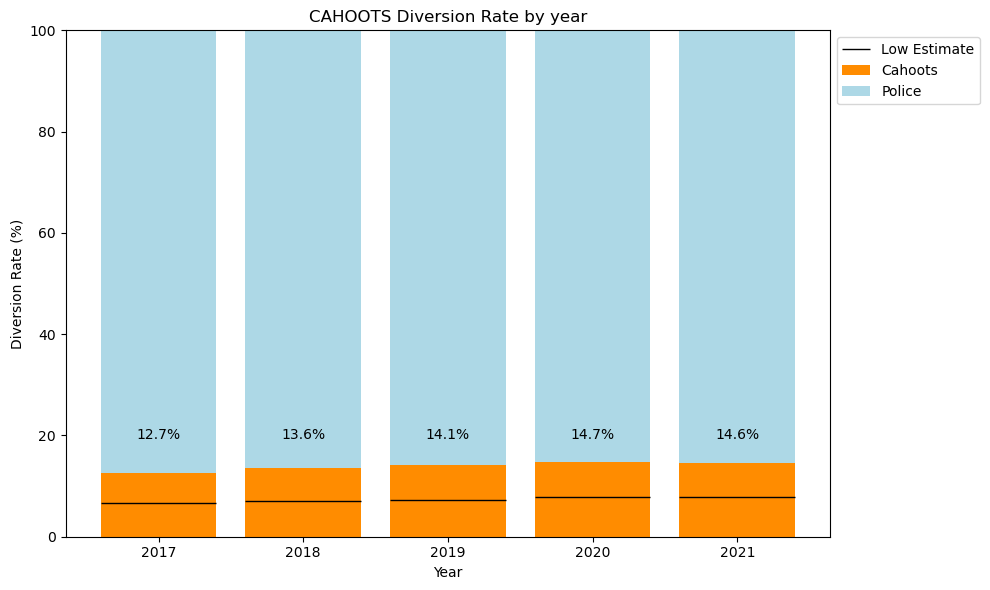

In [19]:
create_diversion_rate_chart(
    diversion_rates_by_year,
    rate_key='Adjusted Divert Rate with Check Welfare Adjustment (high)',
    low_estimate_key='Adjusted Divert Rate with Check Welfare Adjustment (low)',
    title='CAHOOTS Diversion Rate by year',
    rate_label='Cahoots',
    low_estimate_label='Low Estimate' 
)

In [20]:
import pandas as pd

def run_police_diversions_by_incident(cleaned_data, welfare_prop, top_n, transport_prop=0, assist_prop=0, suicide_prop=0):
    """
    Calculates diversion rates by incident type, following the 
    same methodology as `run_police_diversions`.

    Args:
        cleaned_data (pd.DataFrame): The cleaned incident data.
        welfare_prop (float): Proportion for adjusting Check Welfare calls.
        transport_prop (float, optional): Proportion for adjusting Transport calls.
        assist_prop (float, optional): Proportion for adjusting Assist Public-Police calls.
        suicide_prop (float, optional): Proportion for adjusting Suicidal Subject calls. 

    Returns:
        dict: A dictionary containing diversion rates for each incident type.
    """

    top_cahoots_incidents = cleaned_data[cleaned_data['Cahoots_related'] == 1]['InitialIncidentTypeDescription'].value_counts().nlargest(top_n).index
    
    results = {}

    for incident_type in top_cahoots_incidents:
        incident_data = cleaned_data[cleaned_data['InitialIncidentTypeDescription'] == incident_type]

        # Filtering out the 'SELF' entries from the dataset
        data_filtered = incident_data[incident_data['Call_Source'] != 'SELF']

        # Dataset 1: ALL CAHOOTS ASSOCIATIONS
        cahoots_associations = data_filtered[data_filtered['Cahoots_related'] == 1]

        # Dataset 2: ALL CAHOOTS DISPATCHED CFS
        cahoots_dispatched = cahoots_associations.dropna(subset=['Call_First_Dispatched_Time'])
        cahoots_dispatched = cahoots_dispatched.drop_duplicates(subset='IncidentNumber', keep='first')

        # Dataset 4: ALL CAHOOTS ONLY ASSOCIATIONS
        cahoots_only_associations = cahoots_associations[
            (cahoots_associations['PrimaryUnitCallSign'] == "CAHOOT") & (cahoots_associations['IsPrimary'] == 1)
        ]

        # Dataset 5: CAHOOTS ONLY ARRIVED CFS
        cahoots_only_arrived = cahoots_only_associations.dropna(subset=['Call_First_On_Scene'])
        cahoots_only_arrived = cahoots_only_arrived.drop_duplicates(subset='IncidentNumber', keep='first')

        # Dataset 6: Total CAHOOTS / EPD responses
        data_unique_incidents = data_filtered.drop_duplicates(subset='IncidentNumber', keep='first')
        combined_cahoots_epd_responses = data_unique_incidents[
            ~(data_unique_incidents["Call_First_Dispatched_Time"].isna())
        ]  

        # Calculate total calls
        total_calls = data_unique_incidents.shape[0]

        # Filter top 3 CAHOOTS CFS natures arrive
        top_3_natures = ['ASSIST PUBLIC- POLICE', 'CHECK WELFARE', 'TRANSPORT']
        top_3_cahoots_natures = cahoots_only_arrived[cahoots_only_arrived['InitialIncidentTypeDescription'].isin(top_3_natures)]
        top_3_cahoots_natures_count = top_3_cahoots_natures.shape[0]

        # Gross Divert Rates
        gross_divert_rate_1 = (cahoots_associations.shape[0] / total_calls) * 100 if total_calls > 0 else 0
        gross_divert_rate_2 = (cahoots_dispatched.shape[0] / total_calls) * 100 if total_calls > 0 else 0
        gross_divert_rate_3 = (cahoots_only_arrived.shape[0] / total_calls) * 100 if total_calls > 0 else 0 

        # Divert Rate without top 3 incident types 
        adjusted_cahoots_only_arrived = cahoots_only_arrived.shape[0] - top_3_cahoots_natures_count
        adjusted_divert_rate = (adjusted_cahoots_only_arrived / total_calls) * 100 if total_calls > 0 else 0 

        # Divert Rate without top 3 incident types Arrived only 
        denominator = (combined_cahoots_epd_responses.shape[0] - top_3_cahoots_natures_count)
        adjusted_cahoots_police_arrived = ((cahoots_only_arrived.shape[0] - top_3_cahoots_natures_count) / denominator) * 100 if denominator > 0 else 0

        # Applying adjustments to specific call types 
        likely_check_welfare_diverts_dispatch = (cahoots_dispatched[cahoots_dispatched["InitialIncidentTypeDescription"] == 'CHECK WELFARE'].shape[0]) * welfare_prop
        likely_transport_diverts_dispatch = (cahoots_dispatched[cahoots_dispatched["InitialIncidentTypeDescription"] == 'TRANSPORT'].shape[0]) * transport_prop
        likely_assist_diverts_dispatch = (cahoots_dispatched[cahoots_dispatched["InitialIncidentTypeDescription"] == 'ASSIST PUBLIC- POLICE'].shape[0]) * assist_prop
        likely_suicide_diverts = (cahoots_dispatched[cahoots_dispatched["InitialIncidentTypeDescription"] == 'SUICIDAL SUBJECT'].shape[0]) * suicide_prop

        likely_divert_sum = likely_check_welfare_diverts_dispatch + likely_transport_diverts_dispatch + likely_assist_diverts_dispatch + likely_suicide_diverts

        # Low estimate
        adjusted_divert_rate_with_welfare = ((likely_divert_sum) / total_calls) * 100 if total_calls > 0 else 0 

        # High estimate
        denominator_high = ((combined_cahoots_epd_responses.shape[0]) - (cahoots_dispatched.shape[0] - likely_divert_sum))
        adjusted_divert_rate_with_welfare_high = (likely_divert_sum / denominator_high) * 100 if denominator_high > 0 else 0
        
        results[incident_type] = {
            "Gross Divert Rate 1 (All Cahoots Associations)": gross_divert_rate_1,
            "Gross Divert Rate 2 (All Cahoots Dispatched CFS)": gross_divert_rate_2,
            "Gross Divert Rate 3 (All Cahoots Arrived CFS)": gross_divert_rate_3,
            "Adjusted Divert Rate (Excluding Top 3 Natures)": adjusted_divert_rate,
            "Adjusted Divert Rate (Excluding Top 3 Natures Arrived only)": adjusted_cahoots_police_arrived,
            "Adjusted Divert Rate with Check Welfare Adjustment (low)": adjusted_divert_rate_with_welfare,
            "Adjusted Divert Rate with Check Welfare Adjustment (high)": adjusted_divert_rate_with_welfare_high
        }
        
    return results

# Example usage:
diversion_rates_by_incident = run_police_diversions_by_incident(
    CAD_data_cleaned, 
    welfare_prop=0.74, 
    top_n=5  # Calculate for the top 5 Cahoots incident types
)

# Print or process the results
for incident_type, rates in diversion_rates_by_incident.items():
    print(f"Incident Type: {incident_type}")
    print(rates)
    print("-" * 20)

Incident Type: ASSIST PUBLIC- POLICE
{'Gross Divert Rate 1 (All Cahoots Associations)': 91.35234816818294, 'Gross Divert Rate 2 (All Cahoots Dispatched CFS)': 72.30882714531596, 'Gross Divert Rate 3 (All Cahoots Arrived CFS)': 64.4160314728301, 'Adjusted Divert Rate (Excluding Top 3 Natures)': 0.0, 'Adjusted Divert Rate (Excluding Top 3 Natures Arrived only)': 0.0, 'Adjusted Divert Rate with Check Welfare Adjustment (low)': 0.0, 'Adjusted Divert Rate with Check Welfare Adjustment (high)': 0.0}
--------------------
Incident Type: CHECK WELFARE
{'Gross Divert Rate 1 (All Cahoots Associations)': 62.95096597200417, 'Gross Divert Rate 2 (All Cahoots Dispatched CFS)': 51.466723958419415, 'Gross Divert Rate 3 (All Cahoots Arrived CFS)': 44.17359401080831, 'Adjusted Divert Rate (Excluding Top 3 Natures)': 0.0, 'Adjusted Divert Rate (Excluding Top 3 Natures Arrived only)': 0.0, 'Adjusted Divert Rate with Check Welfare Adjustment (low)': 38.08537572923036, 'Adjusted Divert Rate with Check Welfar

In [21]:
diversion_rates_by_year = {}
for year in range(2017, 2022): 
    yearly_data = CAD_data_cleaned[CAD_data_cleaned["Call_Created_Time"].dt.year == year]
    diversion_rates_by_year[year] = run_police_diversions(yearly_data, welfare_prop)

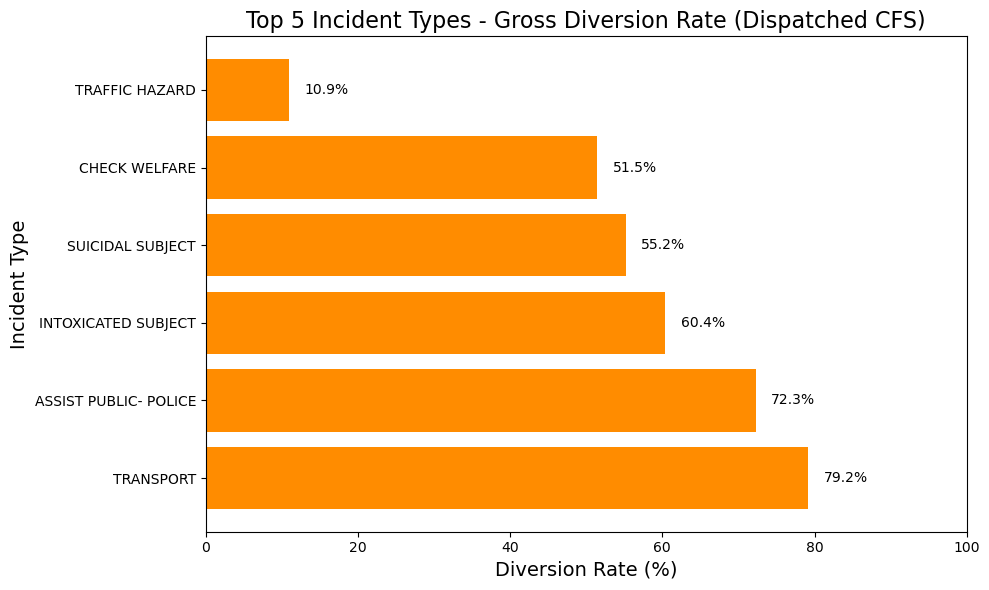

In [22]:
import matplotlib.pyplot as plt
import pandas as pd 

# ... (Your existing `run_police_diversions_by_incident` function) ...

def plot_diversion_rates_by_incident(diversion_data, rate_key, top_n=10, title=None):
    """
    Creates a bar chart comparing diversion rates for different incident types.

    Args:
        diversion_data (dict): The dictionary returned by 
                              `run_police_diversions_by_incident`.
        rate_key (str): The specific diversion rate key to plot from 
                          the `diversion_data` dictionary (e.g., 
                          'Gross Divert Rate 2 (All Cahoots Dispatched CFS)').
        top_n (int, optional): The number of top incident types to display. 
                                Defaults to 10.
        title (str, optional): Custom title for the plot. If None, a 
                                default title is used. 
    """

    # Extract data for the specified rate
    incident_types = list(diversion_data.keys())
    rates = [diversion_data[incident][rate_key] for incident in incident_types]

    # Sort by rate (descending)
    sorted_data = sorted(zip(rates, incident_types), reverse=True)
    rates, incident_types = zip(*sorted_data)

    plt.figure(figsize=(10, 6))
    plt.barh(incident_types[:top_n], rates[:top_n], color='darkorange')

    plt.xlabel('Diversion Rate (%)', fontsize=14) 
    plt.ylabel('Incident Type', fontsize=14)
    plt.title(title if title else f'Top {top_n} Incident Types - {rate_key}', fontsize=16)
    plt.xlim(0, 100) 

    # Add labels to the bars
    for i, v in enumerate(rates[:top_n]):
        plt.text(v + 2, i, f'{v:.1f}%', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()


# Example Usage:
diversion_rates_by_incident = run_police_diversions_by_incident(CAD_data_cleaned, 0.74, top_n=8)

plot_diversion_rates_by_incident(
    diversion_data=diversion_rates_by_incident,
    rate_key="Gross Divert Rate 2 (All Cahoots Dispatched CFS)",
    top_n=6,
    title="Top 5 Incident Types - Gross Diversion Rate (Dispatched CFS)"
)

In [23]:
from scripts.tree import create_treemap

C:\Users\Nathan Burton\AppData\Local\Temp\ipykernel_15876\1687362495.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab20_colormap = cm.get_cmap('tab20b', 20)  # Ensure it has 20 colors


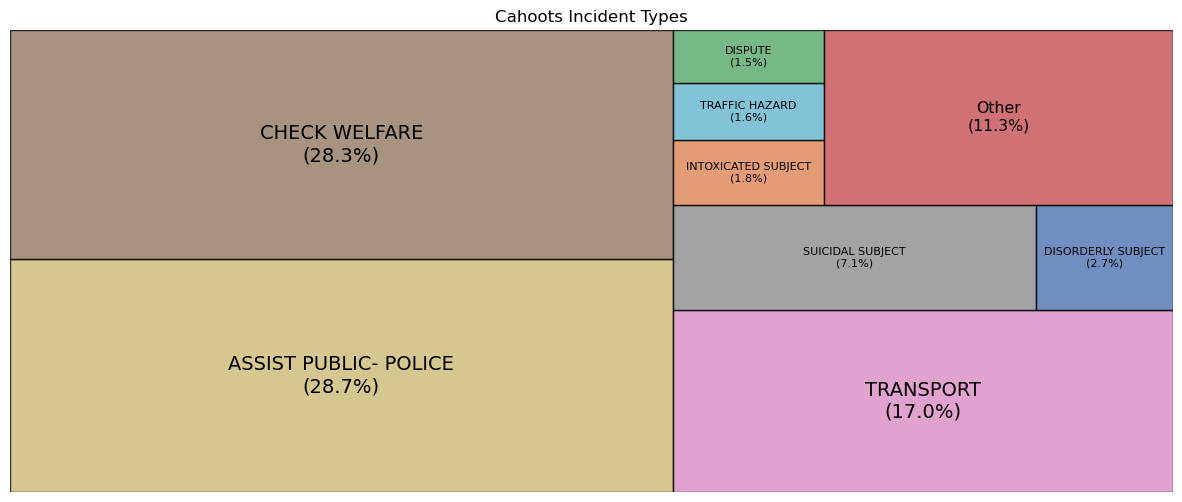

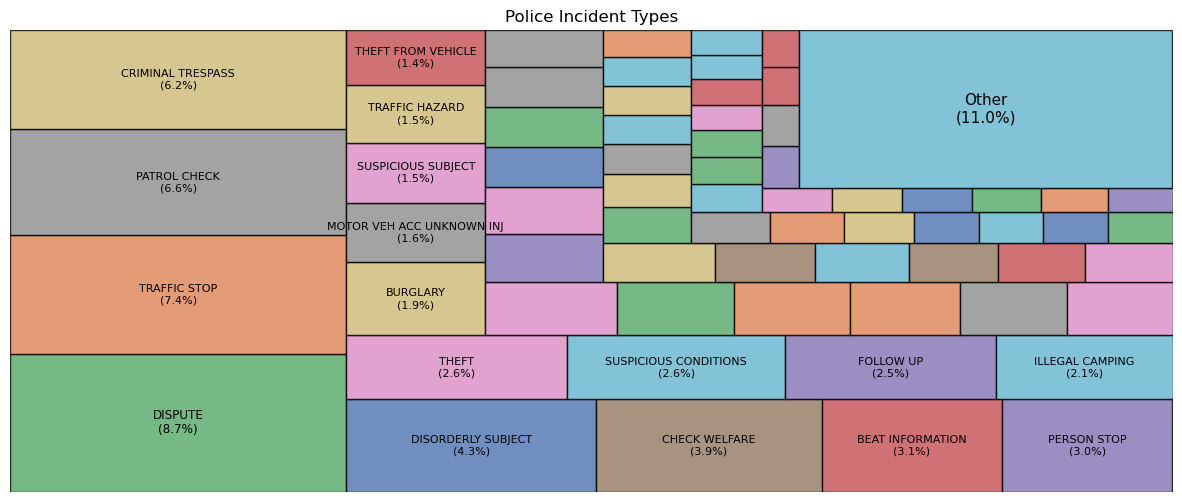

In [52]:
import matplotlib 
import matplotlib.cm as cm

tab20_colormap = cm.get_cmap('tab20b', 20)  # Ensure it has 20 colors

# Get the colors as hex strings
tab20_colors = [matplotlib.colors.rgb2hex(tab20_colormap(i)) for i in range(tab20_colormap.N)]


import seaborn as sns
import matplotlib.colors as mcolors

# Generate a palette with 20 unique colors
colors = sns.color_palette("deep")
hex_colors = [mcolors.rgb2hex(color) for color in colors]

colorblind_friendly_palette = [

    '#009E73',  # Green
    '#E69F00',  # Gold/Orange
    '#56B4E9',  # Light Blue
    '#D55E00',  # Red-Orange/Brown
    '#CC79A7',  # Pink/Purple
    '#F0E442',  # Yellow (use sparingly)
    '#999999',  # Gray
    '#363737',  # Blackish
    '#80B1D3',  # Light Blue
    '#FDB462',  # Light Orange
    '#B3DE69',  # Light Green
    '#BC80BD',  # Purple
    '#FFED6F',  # Light Yellow
    '#FB8072',  # Salmon
    '#1F78B4',  # Dark Blue
]

cahoots_data = CAD_data_cleaned[CAD_data_cleaned['Cahoots_related'] == 1]
police_data = CAD_data_cleaned[CAD_data_cleaned['Cahoots_related'] == 0]

create_treemap(cahoots_data, 'Cahoots Incident Types', top_n=8, group_others=True, max_legend_entries=10, show_labels=True, color_list=hex_colors)
create_treemap(police_data, 'Police Incident Types', top_n=66, group_others=True, max_legend_entries=10, show_labels=True, color_list=hex_colors, min_label_area_ratio=0.014)